In [10]:
from matplotlib import pyplot as plt
import numpy as np


print(plt.rcParams["figure.figsize"])

[6.4, 4.8]


In [11]:
class PrecomputedMOTTracker():

    def __init__(self, seq_path=None):
        self.seq_dets = np.loadtxt(seq_path, delimiter=',')
        
        self.last_frame = int(self.seq_dets[:, 0].max())
    
    def __call__(self, frame):
        tracks = self.seq_dets[self.seq_dets[:, 0] == frame, :]
        return tracks

In [12]:
def center(tracks):
    cx = tracks[..., 0] + (tracks[..., 2] / 2.0)
    cy = tracks[..., 1] + (tracks[..., 3] / 2.0)

    return cx, cy

def speed(tracks1, tracks2):

    cx1, cy1 = center(tracks1)
    cx2, cy2 = center(tracks2)

    dx = cx2 - cx1
    dy = cy2 - cy1

    return dx, dy

def compute_iou(tracks1, tracks2):
    xx1 = np.maximum(tracks1[..., 0], tracks2[..., 0])
    yy1 = np.maximum(tracks1[..., 1], tracks2[..., 1])
    xx2 = np.minimum(tracks1[..., 0] + tracks1[..., 2], tracks2[..., 0] + tracks2[..., 2])
    yy2 = np.minimum(tracks1[..., 1] + tracks1[..., 3], tracks2[..., 1] + tracks2[..., 3])

    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)

    intersection_area_matrix = w * h

    area_test = tracks1[..., 2] * tracks1[..., 3]
    area_gt = tracks2[..., 2] * tracks2[..., 3]

    union_area_matrix = (area_test + area_gt - intersection_area_matrix)

    iou = intersection_area_matrix / union_area_matrix

    return iou

def compute_ciou(tracks1, tracks2):
    distance = lambda cx1, cy1, cx2, cy2 : (cx1 - cx2) ** 2 + (cy1 - cy2) ** 2

    max_ar_dist = np.pi ** 2. / 4.0 # Normalization term
    ar_distance = lambda w1, h1, w2, h2 : ((np.arctan(w2 / (h2 + 1)) - np.arctan(w1 / (h1 + 1))) ** 2) / max_ar_dist # cuadratic angular distance

    iou = compute_iou(tracks1, tracks2)

    cx1, cy1 = center(tracks1)
    cx2, cy2 = center(tracks2)

    inner_diag = distance(cx1, cy1, cx2, cy2)

    xx1 = np.minimum(tracks1[..., 0], tracks2[..., 0])
    yy1 = np.minimum(tracks1[..., 1], tracks2[..., 1])
    xx2 = np.maximum(tracks1[..., 0] + tracks1[..., 2], tracks2[..., 0] + tracks2[..., 2])
    yy2 = np.maximum(tracks1[..., 1] + tracks1[..., 3], tracks2[..., 1] + tracks2[..., 3])

    outer_diag = distance(xx1, yy1, xx2, yy2)

    ioo_dist = inner_diag / outer_diag
    ar_dist = ar_distance(tracks1[..., 2], tracks1[..., 3], tracks2[..., 2], tracks2[..., 3])

    S = 1 - iou
    S[S == 0] = np.finfo(S.dtype).eps
    ar_cost = ar_dist / (ar_dist + S)

    ciou_matrix = iou - ioo_dist - ar_cost * ar_dist
    ciou_matrix = (ciou_matrix + 1.) / 2.0
    return ciou_matrix


In [13]:

gt_tracker = PrecomputedMOTTracker('./DATA/output_4_gt.txt')
#tracker = PrecomputedMOTTracker('./OUTPUT/ocsort_tracking_output_4_kalman.txt')
#tracker = PrecomputedMOTTracker('./OUTPUT/output_4_dets_pca.txt')
tracker = PrecomputedMOTTracker('./OUTPUT/output_4_kalman_pca.txt')

In [14]:
def concat_speed_and_iou_and_ciou(tracker: PrecomputedMOTTracker):
    tck_id_sort = np.argsort(tracker.seq_dets[:, 1], kind="stable")

    first_mask = ~(tracker.seq_dets[tck_id_sort[:-1], 1] == tracker.seq_dets[tck_id_sort[1:], 1])
    discontinuity_mask = ~((tracker.seq_dets[tck_id_sort[:-1], 0] + 1) == tracker.seq_dets[tck_id_sort[1:], 0])

    dx, dy = speed(tracker.seq_dets[tck_id_sort[:-1], 2:6], tracker.seq_dets[tck_id_sort[1:], 2:6])
    iou = compute_iou(tracker.seq_dets[tck_id_sort[1:], 2:6], tracker.seq_dets[tck_id_sort[:-1], 2:6])
    ciou = compute_ciou(tracker.seq_dets[tck_id_sort[1:], 2:6], tracker.seq_dets[tck_id_sort[:-1], 2:6])
    
    # NOTE: Discontinuity mask could be used for dividing by the number of frames between detections

    dx[first_mask & discontinuity_mask] = np.nan
    dy[first_mask & discontinuity_mask] = np.nan
    iou[first_mask & discontinuity_mask] = np.nan
    ciou[first_mask & discontinuity_mask] = np.nan

    sorted_seqs = np.hstack(
        (tracker.seq_dets[tck_id_sort].reshape(-1, 10),
         np.concatenate(([np.nan], dx)).reshape(-1, 1),
         np.concatenate(([np.nan], dy)).reshape(-1, 1),
         np.concatenate(([np.nan], iou)).reshape(-1, 1),
         np.concatenate(([np.nan], ciou)).reshape(-1, 1))
    )
    tracker.seq_dets = np.empty(sorted_seqs.shape)
    tracker.seq_dets[tck_id_sort] = sorted_seqs

    return tracker

Ground Truth speed
	Mean: 17.77 px/frame
	Variance: 151.67

from 100 to 425.15 there are 15 elements


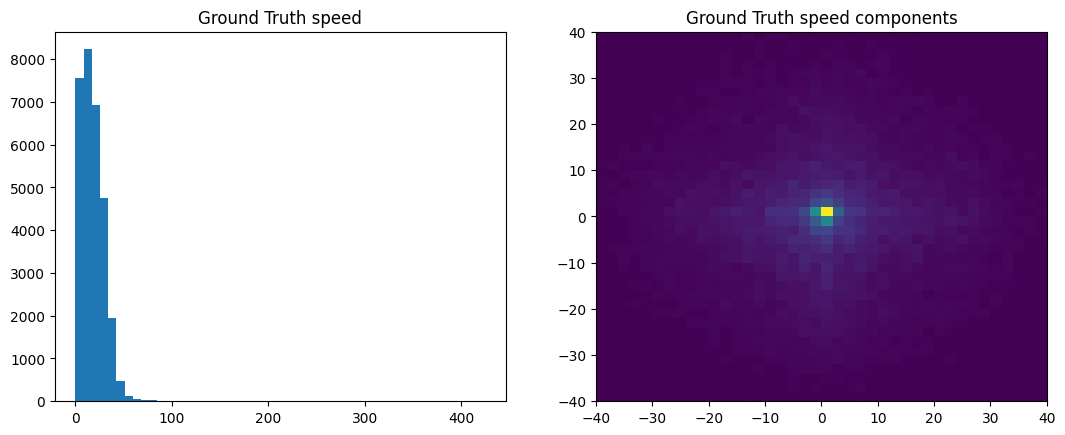

In [15]:
# Speed of gt_tracks, histogram, mean and variance
if gt_tracker.seq_dets.shape[-1] == 10:
    concat_speed_and_iou_and_ciou(gt_tracker)

gt_valid_mask = np.isfinite(gt_tracker.seq_dets[:, 13]) # [:, 12] or [:, 13]
gt_speed_mod = np.linalg.norm(gt_tracker.seq_dets[gt_valid_mask, 10:12], axis=1)

gt_speed_mean = np.mean(gt_speed_mod)
gt_speed_var = np.var(gt_speed_mod)

plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_speed_mod, bins=50)
plt.title('Ground Truth speed')

plt.subplot(1, 2, 2)
plt.hist2d(gt_tracker.seq_dets[gt_valid_mask, 10], gt_tracker.seq_dets[gt_valid_mask, 11], bins=40, range=[[-40, 40], [-40, 40]])
plt.title('Ground Truth speed components')

print(f'Ground Truth speed\n\tMean: {gt_speed_mean:,.02f} px/frame\n\tVariance: {gt_speed_var:,.02f}', end='\n\n')
print(f'from 100 to {max(gt_speed_mod):.02f} there are {sum(gt_speed_mod > 100)} elements')

Tracker speed
	Mean: 18.92 px/frame
	Variance: 282.02
from 100 to 629.02 there are 100 elements


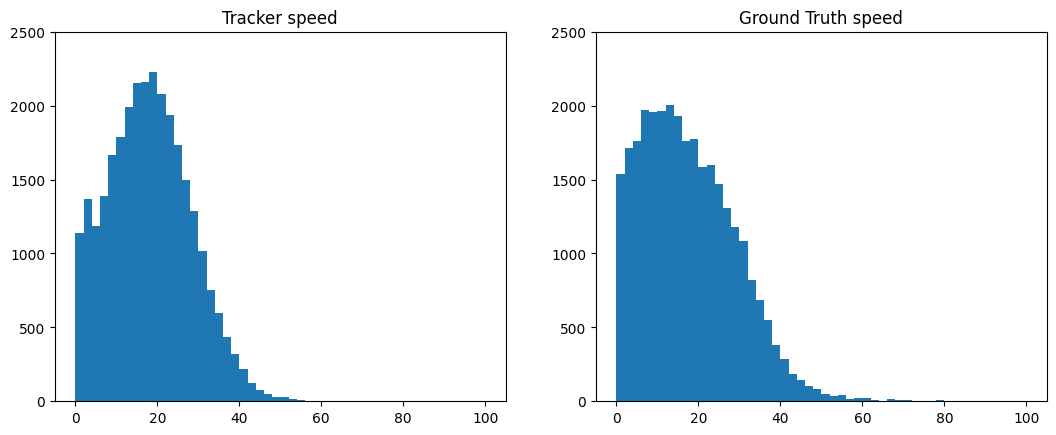

In [16]:
# Speed of tracks, histogram, mean and variance
if tracker.seq_dets.shape[-1] == 10:
    tracker.seq_dets = tracker.seq_dets[tracker.seq_dets[:, 0] <= gt_tracker.seq_dets[:, 0].max(), :]
    concat_speed_and_iou_and_ciou(tracker)

tck_valid_mask = np.isfinite(tracker.seq_dets[:, 12])
tck_speed_mod = np.linalg.norm(tracker.seq_dets[tck_valid_mask, 10:12], axis=1)

tck_speed_mean = np.mean(tck_speed_mod)
tck_speed_var = np.var(tck_speed_mod)

plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(tck_speed_mod, bins=50, range=(0, 100))
plt.ylim(0, 2500)
plt.title('Tracker speed')

plt.subplot(1, 2, 2)
plt.hist(gt_speed_mod, bins=50, range=(0, 100))
plt.ylim(0, 2500)
plt.title('Ground Truth speed')

print(f'Tracker speed\n\tMean: {tck_speed_mean:,.02f} px/frame\n\tVariance: {tck_speed_var:,.02f}')
print(f'from 100 to {max(tck_speed_mod):.02f} there are {sum(tck_speed_mod > 100)} elements')

Text(0.5, 1.0, 'Ground Truth IoU t-1 to t')

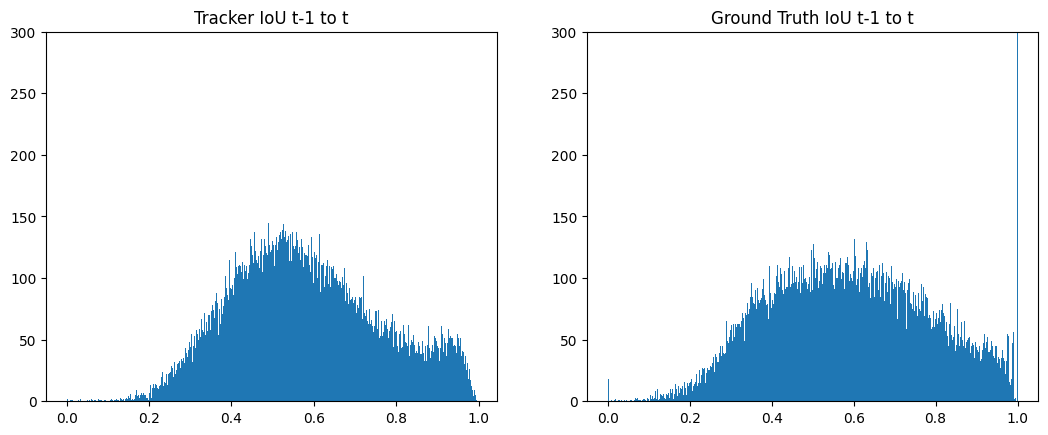

In [17]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(tracker.seq_dets[tck_valid_mask, 12], bins=500)
plt.ylim(0, 300)
plt.title('Tracker IoU t-1 to t')

plt.subplot(1, 2, 2)
plt.hist(gt_tracker.seq_dets[gt_valid_mask, 12], bins=500)
plt.ylim(0, 300)
plt.title('Ground Truth IoU t-1 to t')

Text(0.5, 1.0, 'Ground Truth cIoU t-1 to t')

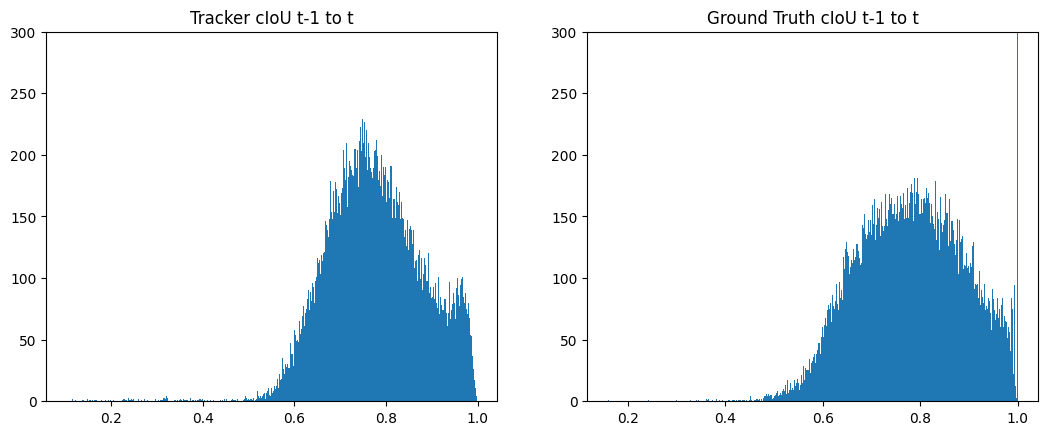

In [18]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(tracker.seq_dets[tck_valid_mask, 13], bins=500)
plt.ylim(0, 300)
plt.title('Tracker cIoU t-1 to t')

plt.subplot(1, 2, 2)
plt.hist(gt_tracker.seq_dets[gt_valid_mask, 13], bins=500)
plt.ylim(0, 300)
plt.title('Ground Truth cIoU t-1 to t')